# Heart Disease UCI
### Predicting Heart Disease

Jarred van de Voort - Business Analytics - April 28 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score,confusion_matrix,precision_recall_curve,auc,roc_curve,recall_score,classification_report 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')#supress warnings

## I. Dataset Exploration


### Feature Set
> 1. Age 
> 2. Sex 
> 3. The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
> 4. Resting blood pressure 
> 5. Serum cholestoral in mg/dl 
> 6. Fasting blood sugar > 120 mg/dl
> 7. Resting electrocardiographic results (values 0,1,2)
> 8. Maximum heart rate achieved 
> 9. Exercise induced angina 
> 10. ST depression induced by exercise relative to rest 
> 11. The slope of the peak exercise ST segment 
> 12. Number of major vessels (0-3) colored by flourosopy 
> 13. Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
> 14. Heart disease (0 = no, 1 = yes)

In [2]:
#Dataset source - https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df = pd.read_csv('datasets/heart.csv')
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [3]:
#Rename column names for easier interpretation
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
df.head()

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                        0            2.3         0                  0   
1                        0            3.5         0                  0   
2                        0            1.4         2                  0   
3                        0            0.8         2                  0   
4                        1            0.6         2                  0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1

### Data Visualization

#### Class Balance
It's a good idea to get a sense of our target class balance - or imbalance, which may require resampling. As shown below, the dataset contains roughly the same number of each class suggesting that no resampling will be needed.

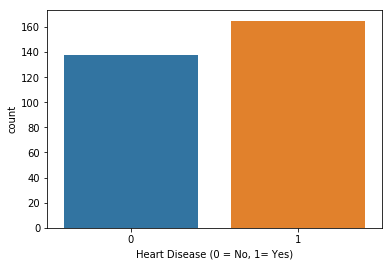

In [4]:
sns.countplot("target",data=df)
plt.xlabel("Heart Disease (0 = No, 1= Yes)")
plt.show()

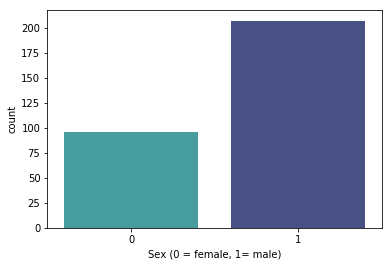

In [5]:
sns.countplot("sex", data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

#### Feature Distributions
By plotting the distribution and relationship between our features we can start to get a more comprehensive picture of our dataset. This also enables better hypothesization that can inform our feature engineering and model selection.

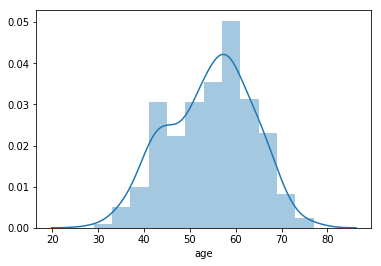

In [6]:
#Here we see that age is normally distributed
sns.distplot(df['age'])

We might hypothesize that age and cholestorol are positively correlated. The scatter plot and correlation coefficient suggests that there is a small, positive correlation between age and cholestrol.

Correlation Coefficient: 


0.2136779565595618

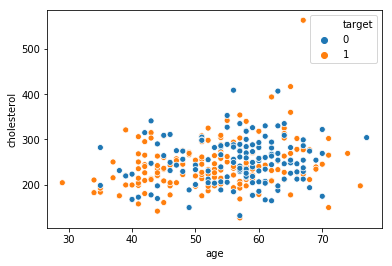

In [7]:
sns.scatterplot(x="age", y="cholesterol", hue="target", data=df)
print("Correlation Coefficient: ")
df['age'].corr(df['cholesterol'])#Correlation coeff

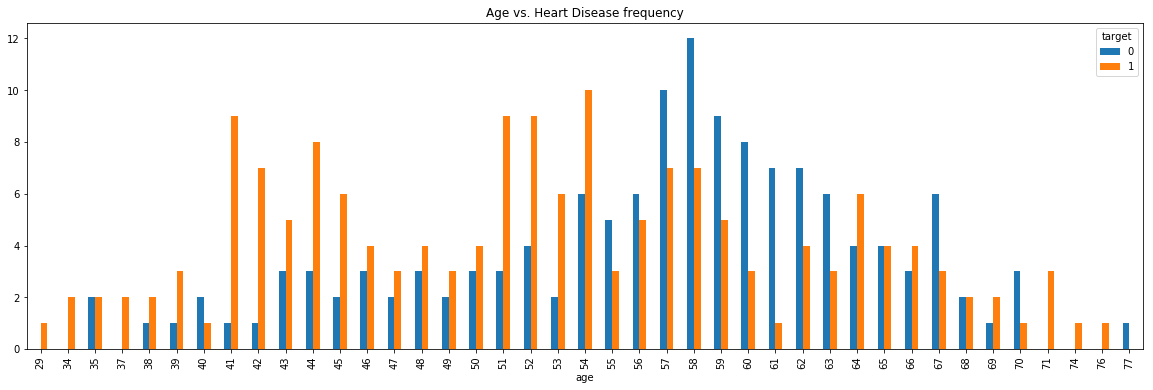

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Age vs. Heart Disease frequency')
plt.show()

#### Detecting Skewness
Skewness may have considerable effects on the training of our model. To demonstrate this better, let's take an example of Linear Regression. Listed below are the assumptions for a linear regression model:

> Assumptions of Regression:
> 1. Linear relationship
> 2. Multivariate normality
> 3. No or little multicollinearity
> 4. No auto-correlation
> 5. Homoscedasticity (all variables have same variance)

Multivariate normality means that regression requires all its variables to be normal. By having skewed data we violate the assumption of normality.

To detect skewness, we can plot the feature distribution matrix. The distributions below suggest that our data is realtively normally distributed. 

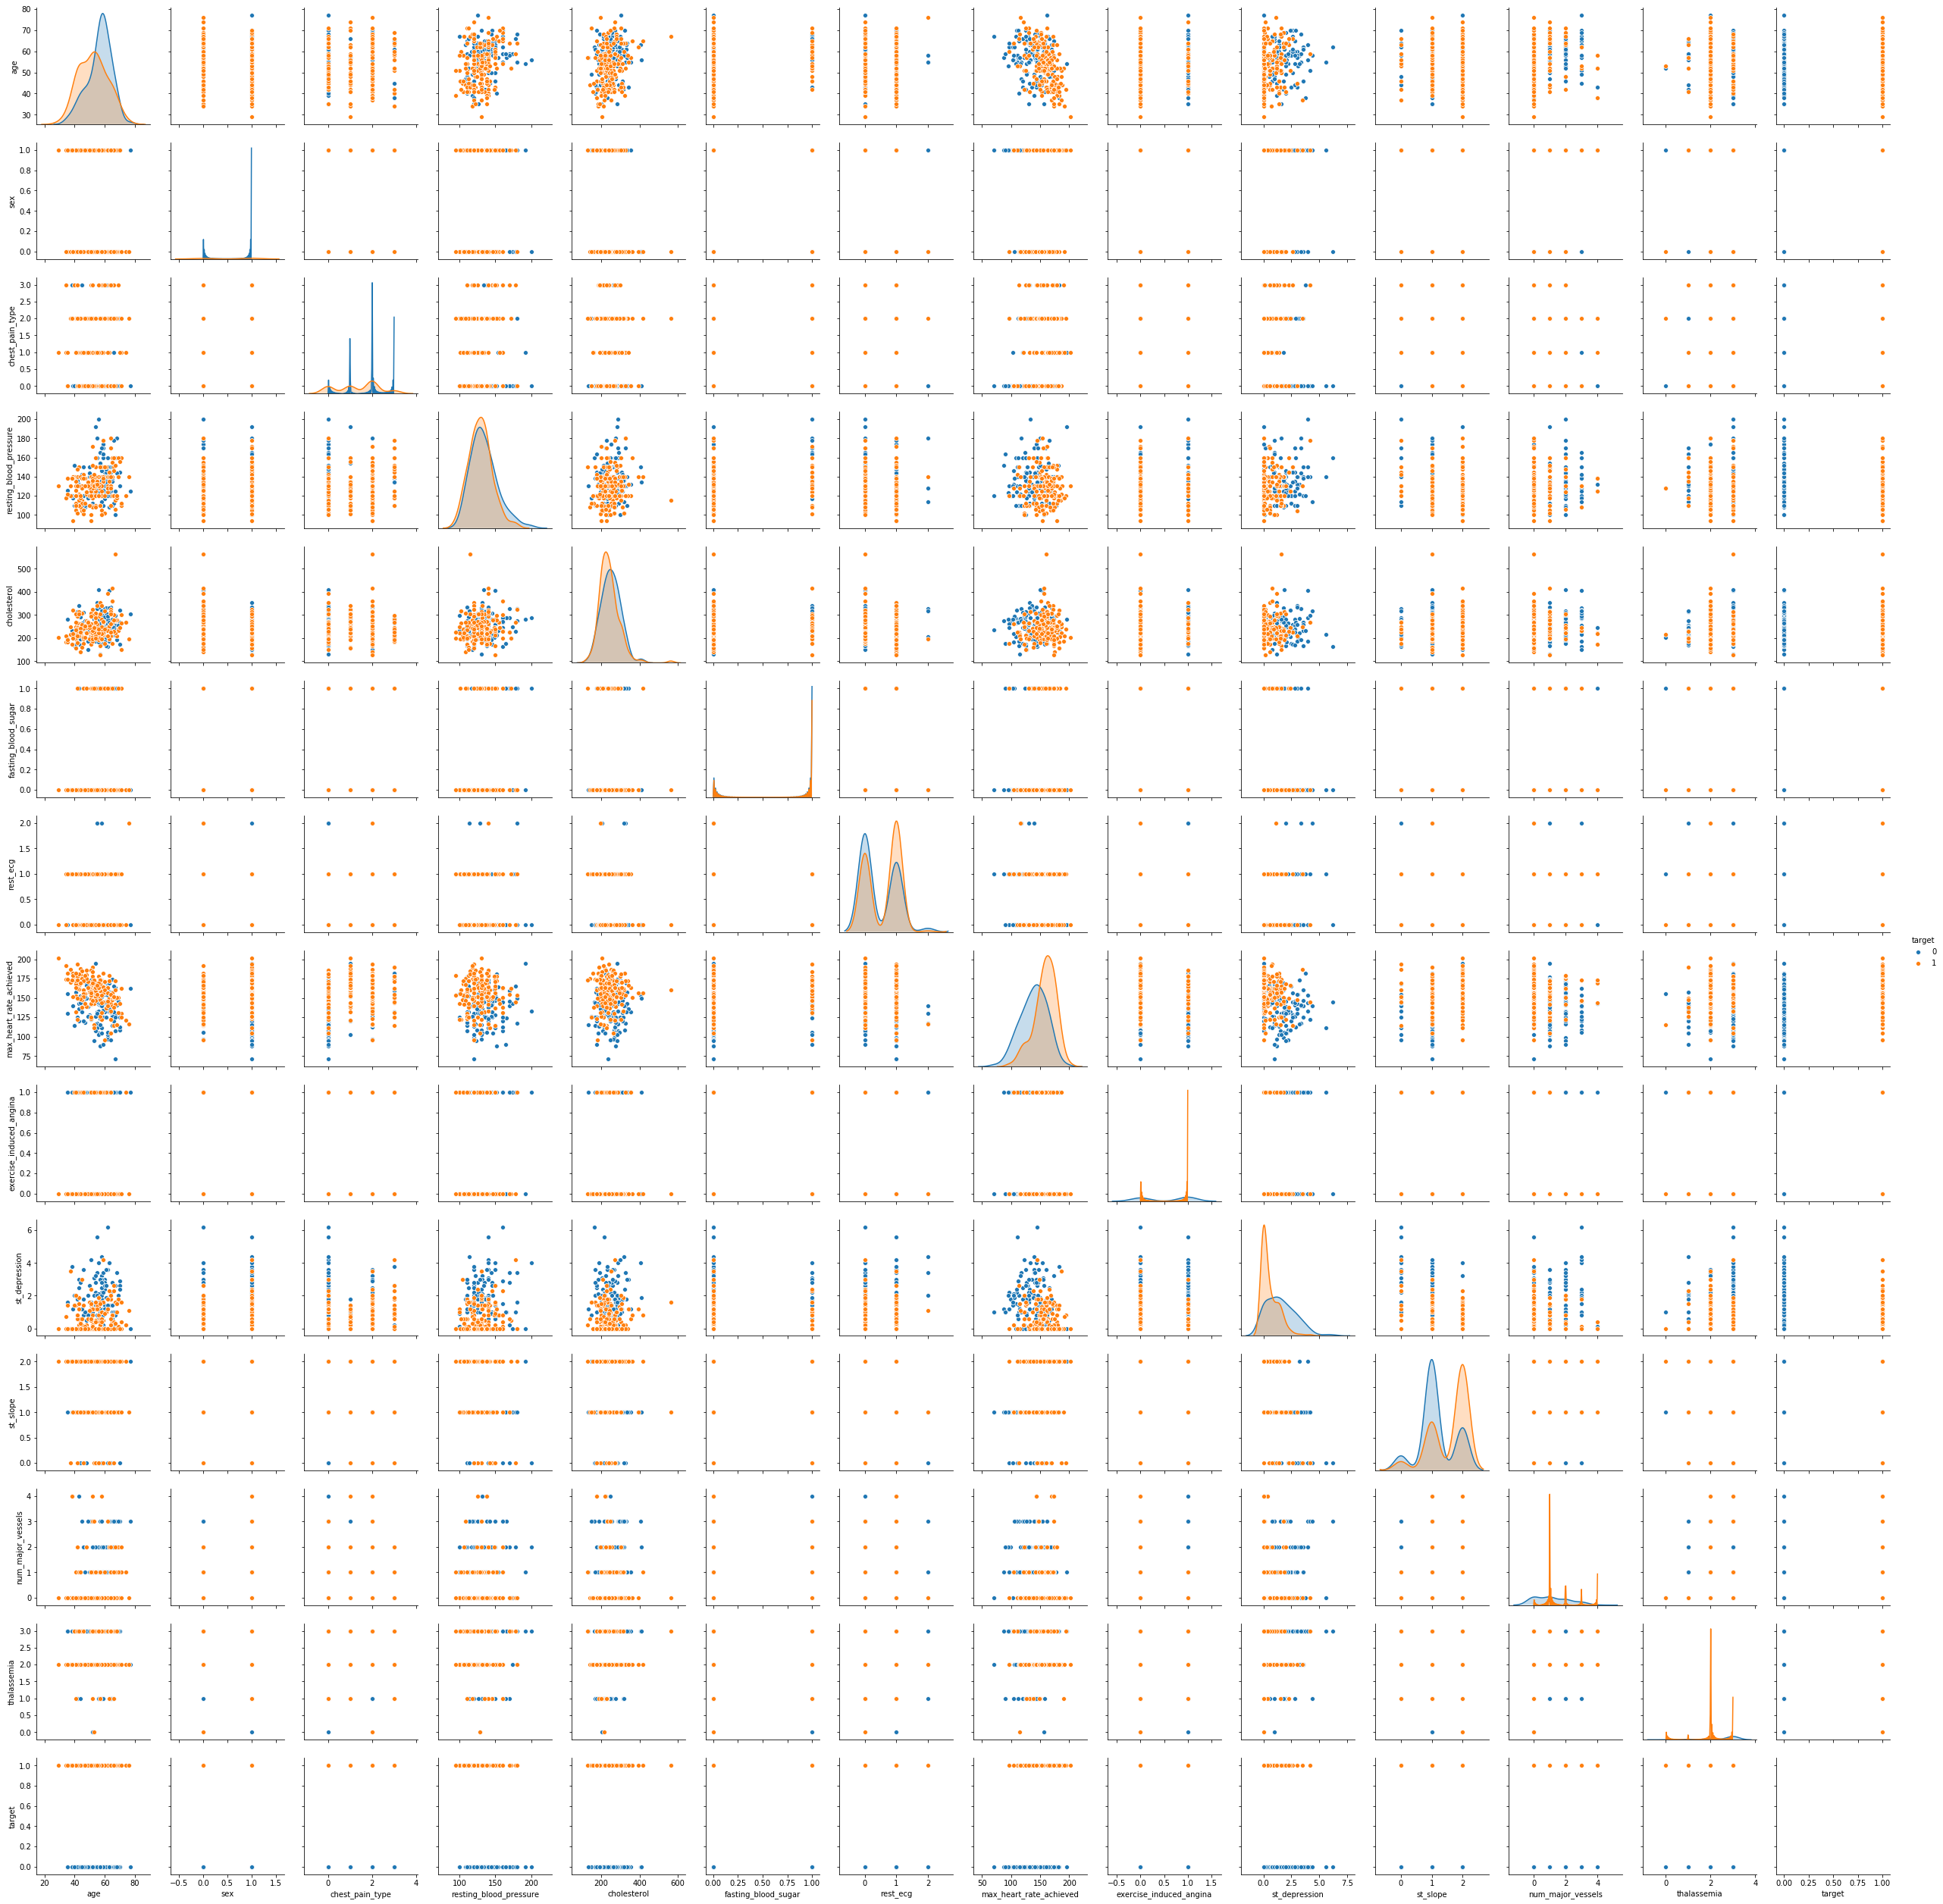

In [9]:
sns.pairplot(data=df, hue = 'target')

The visualization below abstracts the underlying distribution and displays the correlation matrix of each pair of features. For example, we see that age and max heart rate are negatively correlated.

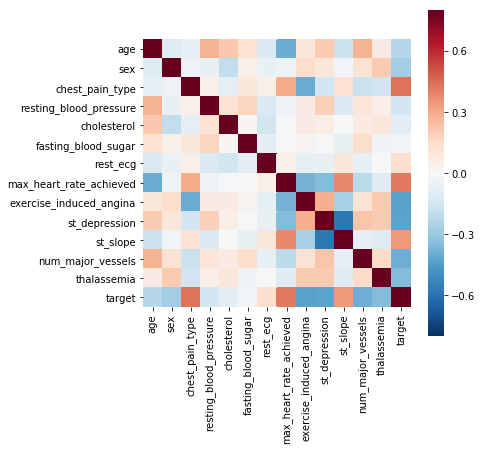

In [10]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax = .8, vmin = -.8, cbar=True, annot=False, square=True, cmap = "RdBu_r");
plt.show()

### II. Feature Engineering

Since chest pain type, thalaseemia and ST slope are categorical features, we'll use get_dummies to encode them.

In [11]:
#Create encoded feature columns
cpt_encoded = pd.get_dummies(df['chest_pain_type'], prefix = "chest_pain_type")
tha_encoded = pd.get_dummies(df['thalassemia'], prefix = "thalassemia")
slp_encoded = pd.get_dummies(df['st_slope'], prefix = "st_slope")

#Combine new columns to original dataframe
frames = [df, cpt_encoded, tha_encoded, slp_encoded]
df = pd.concat(frames, axis = 1)

#Drop the original columns 
df = df.drop(columns = ['chest_pain_type', 'thalassemia', 'st_slope'])
df.head()

age  sex  resting_blood_pressure  cholesterol  fasting_blood_sugar  \
0   63    1                     145          233                    1   
1   37    1                     130          250                    0   
2   41    0                     130          204                    0   
3   56    1                     120          236                    0   
4   57    0                     120          354                    0   

   rest_ecg  max_heart_rate_achieved  exercise_induced_angina  st_depression  \
0         0                      150                        0            2.3   
1         1                      187                        0            3.5   
2         0                      172                        0            1.4   
3         1                      178                        0            0.8   
4         1                      163                        1            0.6   

   num_major_vessels  ...  chest_pain_type_1  chest_pain_type_2  \
0                  0  ...                  0                  0   
1                  0  ...                  0                  1   
2                  0  ...                  1                  0   
3                  0  ...                  1                  0   
4                  0  ...                  0                  0   

   chest_pain_type_3  thalassemia_0  thalassemia_1  thalassemia_2  \
0                  1              0              1              0   
1                  0              0              0              1   
2                  0              0              0              1   
3                  0              0              0              1   
4                  0              0              0              1   

   thalassemia_3  st_slope_0  st_slope_1  st_slope_2  
0              0           1           0           0  
1              0           1           0           0  
2              0           0           0           1  
3              0           0           0           1  
4              0           0           0           1  

[5 rows x 22 columns]

In [12]:
#Seperate features from our class column
X = df.iloc[:, df.columns != 'target']
y = df.iloc[:, df.columns == 'target']

In [13]:
#Checking matrix shape to ensure correct splitting
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (303, 21)
y shape: (303, 1)


In [14]:
#Min-max normalization
X = (X - np.min(X)) / (np.max(X) - np.min(X)).values
X.head()

age  sex  resting_blood_pressure  cholesterol  fasting_blood_sugar  \
0  0.708333  1.0                0.481132     0.244292                  1.0   
1  0.166667  1.0                0.339623     0.283105                  0.0   
2  0.250000  0.0                0.339623     0.178082                  0.0   
3  0.562500  1.0                0.245283     0.251142                  0.0   
4  0.583333  0.0                0.245283     0.520548                  0.0   

   rest_ecg  max_heart_rate_achieved  exercise_induced_angina  st_depression  \
0       0.0                 0.603053                      0.0       0.370968   
1       0.5                 0.885496                      0.0       0.564516   
2       0.0                 0.770992                      0.0       0.225806   
3       0.5                 0.816794                      0.0       0.129032   
4       0.5                 0.702290                      1.0       0.096774   

   num_major_vessels  ...  chest_pain_type_1  chest_pain_type_2  \
0                0.0  ...                0.0                0.0   
1                0.0  ...                0.0                1.0   
2                0.0  ...                1.0                0.0   
3                0.0  ...                1.0                0.0   
4                0.0  ...                0.0                0.0   

   chest_pain_type_3  thalassemia_0  thalassemia_1  thalassemia_2  \
0                1.0            0.0            1.0            0.0   
1                0.0            0.0            0.0            1.0   
2                0.0            0.0            0.0            1.0   
3                0.0            0.0            0.0            1.0   
4                0.0            0.0            0.0            1.0   

   thalassemia_3  st_slope_0  st_slope_1  st_slope_2  
0            0.0         1.0         0.0         0.0  
1            0.0         1.0         0.0         0.0  
2            0.0         0.0         0.0         1.0  
3            0.0         0.0         0.0         1.0  
4            0.0         0.0         0.0         1.0  

[5 rows x 21 columns]

### III. Model Selection

In [15]:
#Split our dataset into test and train sets used for validation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

We will define a robust function allows us to test individual models on our dataset, and then visualize its performance using the confusion matrix and the precision-recall curve. Generally speaking, the higher the area under the PRC, the better overall performance of the model.

In [17]:
def modelReport(name, model, X_train, X_test, y_train, y_test, isSoft):   
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    if(isSoft): 
        y_score = model.predict_proba(X_test)[:,1] #Soft classifier output of class probability 
    else:
        y_score = model.decision_function(X_test) #Hard classifier that finds the distance to the separating hyperplane (i.e SVM)
    
    print("\n----------- " + name + " -----------")
    
    #we'll use a confusion matrix to visualize how well each model performs
    fig= plt.figure(figsize=(6,3))
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap="RdBu_r",annot=True,linewidths=0.5,fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    
    print('Recall:   ',recall_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('AUC:      ',average_precision_score(y_test,y_score))
    
    #sklearn comes with some nifty prebuilt functions for getting the recall and precision of our model
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    #we can plot the PRC curve to view overall model performance
    plt.step(recall, precision, alpha=0.6, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    plt.show()
    
    #classification report is a package in sklearn that gives a nice print out of metrics for each class
    print(classification_report(y_test,y_pred))
    
    return([name, '{0:.2g}'.format(recall_score(y_test,y_pred)), '{0:.2g}'.format(average_precision_score(y_test,y_score))])

### Linear Regression 

With a standard linear regression model, we're able to achieve a precision & recall of 88%! The model correctly predicts 53/61 test classes, with 4 false negatives and 4 false positives. Our AUC is 93% which suggests that there's relatively high performance & a  healthy balance of precision and recall.


----------- Logistic Regression -----------


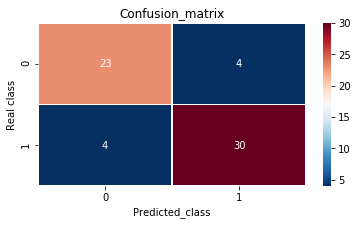

Recall:    0.8823529411764706
Precision: 0.8823529411764706
AUC:       0.9395388265432839


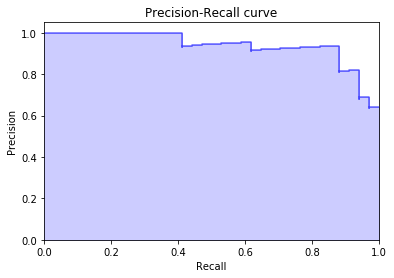

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.88      0.88      0.88        34

   micro avg       0.87      0.87      0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [18]:
LR = LogisticRegression()
LR_report = modelReport("Logistic Regression", LR, X_train,X_test,y_train,y_test, isSoft = False)

### K Nearest Neighbors

With K nearest neighbors our performance drops, with 13 false negative. It's also important to note the relative importance of our metrics. The cost of a false negative is much higher than that of a false postive (not detecting heart disease is much more costly that incorrectly identifying heart disease). Which suggests that recall is a more important metric for determining model performance. Here we see that the KNN model acheives a recall of 61%.


----------- KNN -----------


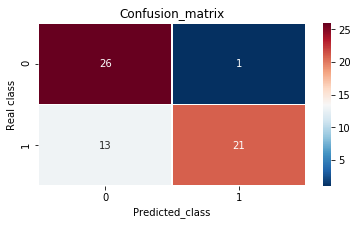

Recall:    0.6176470588235294
Precision: 0.9545454545454546
AUC:       0.8576531954063294


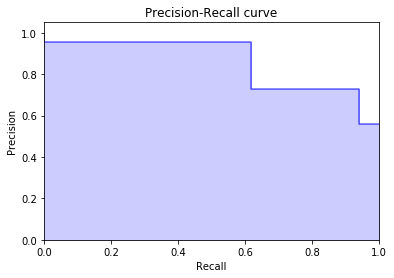

              precision    recall  f1-score   support

           0       0.67      0.96      0.79        27
           1       0.95      0.62      0.75        34

   micro avg       0.77      0.77      0.77        61
   macro avg       0.81      0.79      0.77        61
weighted avg       0.83      0.77      0.77        61



In [19]:
knn = KNeighborsClassifier(n_neighbors = 2) 
knn_report = modelReport("KNN", knn, X_train,X_test,y_train,y_test, isSoft = True)